In [1]:
import pandas as pd
import numpy as np
import os
import re
from nltk import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm._tqdm_notebook import tqdm_notebook

#from utils import Word2vecProcessor
import gzip

import matplotlib.pyplot as plt # as seaborn doesn't seem to address any type of pie-plots
%matplotlib inline

In [2]:
# ignore futurewarning
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Fix & clean

In [2]:
if not os.path.exists("../data/raw/fixed/"):
    os.mkdir("../data/raw/fixed")

In [4]:
# shell code for fixing files

! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/dni_ru.json > ../data/raw/fixed/dni_ru.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/interfax_ru.json > ../data/raw/fixed/interfax_ru.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/kp_ru.json > ../data/raw/fixed/kp_ru.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/meduza_io.json > ../data/raw/fixed/meduza_io.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/mk_ru.json > ../data/raw/fixed/mk_ru.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/novayagazeta_ru.json > ../data/raw/fixed/novayagazeta_ru.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/rg_ru.json > ../data/raw/fixed/rg_ru.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/ria_ru.json > ../data/raw/fixed/ria_ru.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/tass_ru.json > ../data/raw/fixed/tass_ru.fixed.json
! sed -E -e 's/\\\\/\\/g' ../data/raw/newsdump/utro_ru.json > ../data/raw/fixed/utro_ru.fixed.json

In [5]:
! mkdir ../data/raw/cleaned

for filename in os.listdir("../data/raw/fixed/"):
    with open("../data/raw/fixed/{0}".format(filename)) as file:
        print("Processing {0} ...".format(filename))
        df = pd.read_json(file, encoding="utf-8", lines=True)
        df = df.drop_duplicates(subset=["title", "docdate", "text"]).sort_values(by=["docdate"], ascending=False)
        df.to_json("../data/raw/cleaned/{0}".format(filename))

Processing dni_ru.fixed.json ...
Processing kp_ru.fixed.json ...
Processing rg_ru.fixed.json ...
Processing meduza_io.fixed.json ...
Processing tass_ru.fixed.json ...
Processing ria_ru.fixed.json ...
Processing novayagazeta_ru.fixed.json ...
Processing utro_ru.fixed.json ...
Processing interfax_ru.fixed.json ...
Processing mk_ru.fixed.json ...


## Интерфакс

In [3]:
inter = pd.read_json("../data/raw/cleaned/interfax_ru.fixed.json", encoding="utf-8", lines=False)

In [4]:
inter_sub = lambda text : re.sub("^.*-\s", "", text)

In [5]:
tqdm_notebook.pandas(desc="Sub...")

inter["text"] = inter["text"].progress_apply(inter_sub)

In [6]:
inter.head() # beautiful'

,doc_id,docdate,text,title,url
0,124272138,2018-11-20T15:23:00,Россия поставила Анголе четыре истреьителя Су-...,Россия поставила Анголе четыре истребителя Су-...,http://www.interfax.ru/world/638657
1,124272120,2018-11-20T15:10:00,Нерезиденты и дочерние иностранные банки в окт...,Нерезиденты в октябре купили ОФЗ на аукционах ...,http://www.interfax.ru/business/638658
10,124257606,2018-11-20T14:26:00,Отделение Пенсионного фонда России по Самарско...,Нескольких умерших жителей Самары по ошибке пр...,http://www.interfax.ru/russia/638651
100,124067142,2018-11-19T19:47:00,"Глава дипломатии ЕС Федерика Могерини заявила,...","ЕС предпримет меры из-за ""чрезмерных инспекций...",http://www.interfax.ru/world/638545
1000,122766500,2018-11-14T18:45:00,Сотруднику Центрального научно-исследовательск...,Предложенная ученому Кудрявцеву сделка со след...,http://www.interfax.ru/russia/637890


In [8]:
inter.to_json("../data/raw/cleaned/interfax_ru.fixed.json", force_ascii=False)

In [143]:
print("Interfax.ru dump size: {}".format(inter.shape[0]))

Interfax.ru dump size: 89681


In [99]:
inter.docdate.min()

Timestamp('2016-03-23 13:38:00')

In [104]:
print("News entries dated back in 2018: {}".format(inter[inter["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 42606


In [101]:
inter["source"] = inter["url"].apply(lambda x : "Interfax")

## Dni.ru

In [142]:
dni = pd.read_json("../data/raw/cleaned/dni_ru.fixed.json", encoding="utf-8", lines=False)
dni["docdate"] = dni["docdate"].apply(pd.to_datetime)
print("Dni.ru dump size: {0}".format(dni.shape[0]))
dni.head()

Dni.ru dump size: 66503


,doc_id,docdate,text,title,url,source
0,124036509,2018-11-19 17:52:00,Двусмысленные комментарии и туманные намеки зн...,"Последние новости шоу-бизнеса на сегодня, 19 н...",http://www.dni.ru/showbiz/2018/11/19/411651.html,Dni.ru
1,124036520,2018-11-19 17:34:00,Ситуация в Азовском море нынче неспокойная. Ук...,Соловьев лихо унизил зарвавшихся украинцев,http://www.dni.ru/society/2018/11/19/411643.html,Dni.ru
10,124001932,2018-11-19 14:44:00,Первая российская чемпионка мира в женском оди...,Бутырская высказалась о лишних килограммах Заг...,http://www.dni.ru/sport/2018/11/19/411630.html,Dni.ru
100,123382924,2018-11-16 21:00:00,Певцу и композитору Игорю Корнелюку исполнилос...,Отпрыгался: памятник Корнелюку отольют из золота,http://www.dni.ru/showbiz/2018/11/16/411518.html,Dni.ru
1000,119573171,2018-10-29 17:12:00,В Незалежной продолжают строить планы по возвр...,На Украине озвучили план возвращения Крыма,http://www.dni.ru/polit/2018/10/29/410254.html,Dni.ru


In [105]:
print("News entries dated back in 2018: {}".format(dni[dni["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 22251


In [106]:
dni.docdate.min()

Timestamp('2014-08-05 15:31:00')

In [107]:
dni["source"] = dni["url"].apply(lambda x : "Dni.ru")

## КП

In [141]:
kp = pd.read_json("../data/raw/cleaned/kp_ru.fixed.json", encoding="utf-8", lines=False)
kp["docdate"] = kp["docdate"].apply(pd.to_datetime)
print("KP dump size: {0}".format(kp.shape[0]))
kp.head()

KP dump size: 88393


,doc_id,docdate,text,title,url,source
0,56174222,2018-02-06 17:49:45,Варшава планирует ввести ответственность за ра...,Израиль надеется на корректировку нового польс...,https://www.kp.ru/online/news/3013897/,KP
1,56174248,2018-02-06 17:05:13,"Владелец коровника и правоохранители поверили,...",Игрушечный тигр поверг в ужас фермера и полици...,https://www.kp.ru/online/news/3013831/,KP
10,56210221,2018-02-06 20:03:06,Новые суицидальные сообщества не успевают набр...,Роскомнадзор заблокировал около 14 000 «групп ...,https://www.kp.ru/online/news/3013989/,KP
100,208055,2017-02-21 01:00:00,Сегодня - 113 лет со дня рождения советского п...,Генеральная репетиция перестройки прошла еще п...,http://www.kp.ru/daily/26645/3665016/,KP
1000,840690,2017-03-09 00:14:00,8-го марта артист собрал полный «Крокус» и рас...,Александр Панайотов: В этом году на «Евровиден...,http://www.kp.ru/daily/26649.4/3671470/,KP


In [109]:
print("News entries dated back in 2018: {}".format(kp[kp["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 35754


In [110]:
kp.docdate.min()

Timestamp('2006-07-22 01:00:00')

In [111]:
kp["source"] = kp["url"].apply(lambda x : "KP")

## Meduza

In [140]:
meduza = pd.read_json("../data/raw/cleaned/meduza_io.fixed.json", encoding="utf-8", lines=False)
meduza["docdate"] = meduza["docdate"].apply(pd.to_datetime)
print("Meduza.io dump size: {0}".format(meduza.shape[0]))
meduza.head()

Meduza.io dump size: 15950


,doc_id,docdate,text,title,url,source
0,124206356,2018-11-20 11:03:00,Предприятия пищевой промышленности России попр...,Производители мяса и молока предупредили об уб...,https://meduza.io/news/2018/11/20/proizvoditel...,Meduza
1,124205913,2018-11-20 10:54:00,Депутаты Госсовета Татарстана подготовили зако...,Госдуме предложили поднять возраст покупки ору...,https://meduza.io/news/2018/11/20/gosdume-pred...,Meduza
10,124172132,2018-11-20 08:45:00,Вооруженный преступник убил троих человек в бо...,При стрельбе в больнице Чикаго погибли три чел...,https://meduza.io/feature/2018/11/20/pri-strel...,Meduza
100,122478457,2018-11-13 18:16:00,"Заместитель министра экономического развития, ...",«Трансперенси Интернешнл» рассказала о господд...,https://meduza.io/news/2018/11/13/transperensi...,Meduza
1000,110748816,2018-09-02 14:20:00,В Донецке 2 сентября проходит церемония прощан...,В Донецке хоронят Александра Захарченко. ДНР у...,https://meduza.io/short/2018/09/02/v-donetske-...,Meduza


In [113]:
meduza.docdate.min()

Timestamp('2014-11-21 16:26:00')

In [114]:
print("News entries dated back in 2018: {}".format(meduza[meduza["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 4559


In [115]:
meduza["source"] = meduza["url"].apply(lambda x : "Meduza")

## МК

In [116]:
mk = pd.read_json("../data/raw/cleaned/mk_ru.fixed.json", encoding="utf-8", lines=False)
mk["docdate"] = mk["docdate"].apply(pd.to_datetime)
print("MK dump size: {0}".format(mk.shape[0]))
mk.head()

MK dump size: 335


,doc_id,docdate,text,title,url
0,83197039,2018-05-23,Магнитогорский металлургический комбинат удерж...,ММК удерживает лидирующие позиции на рынке под...,http://mmk.ru/press_center/73319/
1,81953263,2018-05-18,Группа ММК приступает к реализации масштабного...,Магнитка инвестирует 3 млрд рублей в новый эко...,http://mmk.ru/press_center/73306/
10,73993522,2018-04-12,Магнитогорский металлургический комбинат прини...,ММК на форуме в Челябинске поделился опытом пр...,http://mmk.ru/press_center/73029/
100,12677154,2017-05-29,Один из крупнейших мировых производителей стал...,НОВЫЙ УРОВЕНЬ ЭНЕРГОСБЕРЕЖЕНИЯ ММК,http://mmk.ru/press_center/publications/71332/
101,12620474,2017-05-29,Магнитогорский металлургический комбинат удост...,ММК удостоился наград салона «Архимед-2017»,http://mmk.ru/press_center/71245/


In [117]:
mk.docdate.min()

Timestamp('2016-03-21 00:00:00')

In [118]:
print("News entries dated back in 2018: {}".format(mk[mk["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 97


In [119]:
mk["source"] = mk["url"].apply(lambda x : "МК")

## Новая газета

In [120]:
novaya = pd.read_json("../data/raw/cleaned/novayagazeta_ru.fixed.json", encoding="utf-8", lines=False)
novaya["docdate"] = novaya["docdate"].apply(pd.to_datetime)
print("Novaya Gazeta dump size: {0}".format(novaya.shape[0]))
novaya.head()

Novaya Gazeta dump size: 34482


,doc_id,docdate,text,title,url
0,124205289,2018-11-20 11:07:00,Басманный суд Москвы заочно арестовал нескольк...,СМИ: российский суд заочно арестовал сирийцев ...,https://www.novayagazeta.ru/news/2018/11/20/14...
1,124198383,2018-11-20 10:45:00,В России за девять месяцев 2018 года от «прест...,СК: в 2018 году более 900 детей погибло от «пр...,https://www.novayagazeta.ru/news/2018/11/20/14...
10,124075255,2018-11-19 20:34:00,Спустя девять лет (!) после гибели в СИЗО Серг...,Прокуроры брызжут ядом,https://www.novayagazeta.ru/articles/2018/11/1...
100,123341715,2018-11-16 19:03:00,Предприниматель и общественный деятель Алексан...,"«Без коллективного ""полковника Захарченко"" они...",https://www.novayagazeta.ru/articles/2018/11/1...
1000,118806384,2018-10-23 22:57:00,Сотрудники следственного комитета Ленинградско...,СМИ: попавшийся на взятке чиновник из Ленингра...,https://www.novayagazeta.ru/news/2018/10/23/14...


In [121]:
novaya.docdate.min()

Timestamp('2011-10-07 07:46:00')

In [122]:
print("News entries dated back in 2018: {}".format(novaya[novaya["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 11925


In [123]:
novaya["source"] = novaya["url"].apply(lambda x : "Novaya Gazeta")

## РГ

In [124]:
rg = pd.read_json("../data/raw/cleaned/rg_ru.fixed.json", encoding="utf-8", lines=False)
rg["docdate"] = rg["docdate"].apply(pd.to_datetime)
print("RG dump size: {0}".format(rg.shape[0]))
rg.head()

RG dump size: 190378


,doc_id,docdate,text,title,url
0,56165297,2018-02-06 17:00:00,В Волгограде болельщиков ЧМ-2018 удивят мюзикл...,"В Волгограде к ЧМ-2018 поставят мюзикл ""Легенд...",https://rg.ru/2018/02/06/reg-ufo/v-volgograde-...
1,56165793,2018-02-06 17:16:00,"Всемирный день ювелира, который прошел 31 янва...",Как дагестанские ювелиры не дают исчезнуть сво...,https://rg.ru/2018/02/06/reg-skfo/kak-dagestan...
10,56194116,2018-02-06 19:08:00,Депутаты земельных парламентов ФРГ находящиеся...,Немецкие депутаты отметили в Крыму пятилетие с...,https://rg.ru/2018/02/06/reg-ufo/nemeckie-depu...
100,56224805,2018-02-06 21:04:00,Американский фондовый рынок накрыла волна расп...,Падение фондового рынка США лишило богачей 114...,https://rg.ru/2018/02/06/padenie-fondovogo-ryn...
1000,500141,2017-03-07 05:08:00,С космодрома Куру во Французской Гвиане запуще...,Старт ракеты-носителя Vega состоялся во Францу...,https://rg.ru/2017/03/07/start-rakety-nositeli...


In [125]:
rg.docdate.min()

Timestamp('2004-09-03 01:10:00')

In [126]:
print("News entries dated back in 2018: {}".format(rg[rg["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 88022


In [127]:
rg["source"] = rg["url"].apply(lambda x : "RG")

## РИА

In [10]:
ria = pd.read_json("../data/raw/cleaned/ria_ru.fixed.json", encoding="utf-8", lines=False)
ria["docdate"] = ria["docdate"].apply(pd.to_datetime)
print("RIA dump size: {0}".format(ria.shape[0]))
ria.head()

RIA dump size: 430292


,doc_id,docdate,text,title,url
0,56165827,2018-02-06 17:34:00,РИА Новости. Бывший премьер Дагестана даже не ...,Бывший премьер Дагестана не будет обжаловать а...,https://ria.ru/incidents/20180206/1514094929.html
1,56165842,2018-02-06 17:34:00,"МОСКВА, 6 фев — РИА Новости. Упавшие под тяжес...",На западе Москвы упавшие деревья повредили сра...,https://ria.ru/incidents/20180206/1514094855.html
10,56166595,2018-02-06 17:34:00,"МОСКВА, 6 фев – РИА Новости. В Украинской прав...",УПЦ: подозреваемые в поджоге часовни в Киеве с...,https://ria.ru/religion/20180206/1514094969.html
100,56225114,2018-02-06 21:17:00,"МОСКВА, 6 фев — РИА Новости. В Госдуме работаю...",В Госдуме работают над законопроектом о паспор...,https://ria.ru/society/20180206/1514108436.html
1000,442460,2017-03-06 20:00:00,РИА НОВОСТИ. ТРАМП ПОРУЧИЛ МИНИСТЕРСТВАМ США У...,Трамп поручил усилить проверку и отбор иностра...,http://ria.ru/world/20170306/1489420492.html


In [24]:
ria_sub = lambda text : re.sub("^.*РИА Новости. ", "", text)

In [31]:
tqdm_notebook.pandas(desc="Sub...")

ria = ria.dropna(subset=["text"]).copy(deep=True)
ria["text"] = ria["text"].progress_apply(ria_sub)

In [32]:
ria.to_json("../data/raw/cleaned/ria_ru.fixed.json", force_ascii=False)

In [129]:
ria.docdate.min()

Timestamp('2011-04-01 11:51:00')

In [130]:
print("News entries dated back in 2018: {}".format(ria[ria["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 150088


In [131]:
ria["source"] = ria["url"].apply(lambda x : "RIA")

## ТАСС

In [132]:
tass = pd.read_json("../data/raw/cleaned/tass_ru.fixed.json", encoding="utf-8", lines=False)
tass["docdate"] = tass["docdate"].apply(pd.to_datetime)
print("TASS dump size: {0}".format(tass.shape[0]))
tass.head()

TASS dump size: 282487


,doc_id,docdate,text,title,url
0,5267,2017-03-05 13:25:00,Единственный мяч на 32-й минуте забил Эрик Бик...,"Урал"" обыграл ""Амкар"" в матче чемпионата России",http://tass.ru/sport/4071850
1,5511,2017-03-05 12:54:00,Пресс-секретарь президента РФ Дмитрий Песков п...,Путин 9 марта встретится в Москве с Нетаньяху,http://tass.ru/politika/4071824
10,5327,2017-03-04 16:01:00,Проект распоряжения уже направлен на рассмотре...,Минкавказ подготовил проект развития каспийско...,http://tass.ru/ekonomika/4071063
100,5365,2017-03-03 16:56:00,Если на начало 2011 года в списке разыскиваемы...,В России до рекордного минимума сократилось чи...,http://tass.ru/armiya-i-opk/4069349
1000,437966,2017-03-06 15:23:00,"В ведомстве сообщили, что к настоящему времени...","МИД РФ выразил признательность всем, кто содей...",http://tass.ru/politika/4074041


In [133]:
tass.docdate.min()

Timestamp('2016-01-02 03:43:00')

In [134]:
print("News entries dated back in 2018: {}".format(tass[tass["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 144657


In [135]:
tass["source"] = tass["url"].apply(lambda x : "TASS")

## Utro.ru

In [136]:
utro = pd.read_json("../data/raw/cleaned/utro_ru.fixed.json", encoding="utf-8", lines=False)
utro["docdate"] = utro["docdate"].apply(pd.to_datetime)
print("Utro.ru dump size: {0}".format(utro.shape[0]))
utro.head()

Utro.ru dump size: 39946


,doc_id,docdate,text,title,url
0,124197845,2018-11-20 10:18:00,Оперная певица дала откровенное интервью извес...,Максакова вышла из себя,https://www.utro.ru/showbiz/2018/11/20/1381202...
1,124197822,2018-11-20 10:10:00,На полуострове то и дело открывается дыра в пр...,Портал в другие миры: тайну Крыма раскрыли,https://www.utro.ru/life/2018/11/20/1381203.shtml
100,124001947,2018-11-19 15:39:00,Жителей срочно эвакуируют \n\nПожар произошел ...,В московской многоэтажке загорелась квартира,https://www.utro.ru/accidents/2018/11/19/13811...
10003,110306362,2018-08-31 13:21:00,ЧП на оборонном предприятии может повториться ...,Дзержинску угрожает новый взрыв на заводе,https://www.utro.ru/accidents/2018/08/31/13723...
10004,110306349,2018-08-31 13:13:00,"Украину придется смириться с тем, что Запад бо...",Киев в бешенстве: Европа отказалась воевать с ...,https://www.utro.ru/politics/2018/08/31/137232...


In [137]:
utro.docdate.min()

Timestamp('2012-07-20 16:14:00')

In [138]:
print("News entries dated back in 2018: {}".format(utro[utro["docdate"]>=pd.to_datetime("2018", format="%Y")].shape[0]))

News entries dated back in 2018: 18186


In [139]:
utro["source"] = utro["url"].apply(lambda x : "Utro.ru")

# Graphs

In [215]:
news = pd.concat([inter, dni, kp, meduza, mk, novaya, rg, ria, tass, utro])

In [217]:
news = news.reset_index(drop=True).copy(deep=True)

In [148]:
print("Size of full news dump: {} entities".format(news.shape[0]))

Size of full news dump: 1238447 entities


In [218]:
news.to_json("../data/raw/newsdump.json", force_ascii=False, compression='gzip')

In [152]:
tqdm_notebook.pandas(desc="Date format preprocess")
news["year"] = news["docdate"].progress_apply(lambda x : int(str(x)[:4]))
news.head()

,doc_id,docdate,text,title,url,source,year
0,124272138,2018-11-20 15:23:00,Россия поставила Анголе четыре истреьителя Су-...,Россия поставила Анголе четыре истребителя Су-...,http://www.interfax.ru/world/638657,Interfax,2018
1,124272120,2018-11-20 15:10:00,Нерезиденты и дочерние иностранные банки в окт...,Нерезиденты в октябре купили ОФЗ на аукционах ...,http://www.interfax.ru/business/638658,Interfax,2018
2,124257606,2018-11-20 14:26:00,Отделение Пенсионного фонда России по Самарско...,Нескольких умерших жителей Самары по ошибке пр...,http://www.interfax.ru/russia/638651,Interfax,2018
3,124067142,2018-11-19 19:47:00,"Глава дипломатии ЕС Федерика Могерини заявила,...","ЕС предпримет меры из-за ""чрезмерных инспекций...",http://www.interfax.ru/world/638545,Interfax,2018
4,122766500,2018-11-14 18:45:00,Сотруднику Центрального научно-исследовательск...,Предложенная ученому Кудрявцеву сделка со след...,http://www.interfax.ru/russia/637890,Interfax,2018


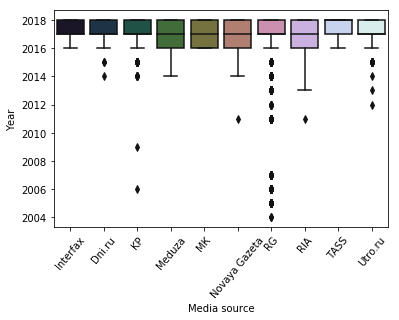

In [153]:
g = sns.boxplot(x="source", y="year", data=news, palette=sns.color_palette("cubehelix", len(news.source.unique())))
g.set_xticklabels(labels=news["source"].unique(), rotation=50)
g.set_xlabel("Media source")
g.set_ylabel("Year")
g

#### idk why i've done the following but it may be useful in some way someday

In [71]:
november = news[news["docdate"]>pd.to_datetime("2018-11-15")]

In [72]:
print("Размер дампа позже середины ноября 2018: {}".format(november.shape[0]))

Размер дампа позже середины ноября 2018: 9735


In [86]:
for s in news.source.unique():
    print("Источник \"{0}\": {1}".format(s, november[november["source"]==s].shape[0]))
    
    
num_bait = november[(november["source"]=="Dni.ru") | 
                (november["source"]=="Утро.ру") | 
                (november["source"]=="КП")].shape[0]    

print("\nПотенциального кликбейта: {0} или {1}%".format(num_bait, round(num_bait/november.shape[0]*100, ndigits=1)))

Источник "Интерфакс": 679
Источник "Dni.ru": 305
Источник "КП": 622
Источник "Meduza": 174
Источник "МК": 2
Источник "Новая Газета": 175
Источник "РГ": 1600
Источник "РИА": 2335
Источник "ТАСС": 3527
Источник "Утро.ру": 316

Потенциального кликбейта: 1243 или 12.8%


In [87]:
november.to_json("data/november.json", force_ascii=False, compression='zip')

## Pie-chart on news dated back in 2018

In [219]:
news18 = news[news["docdate"]>pd.to_datetime("2018", format="%Y")].reset_index(drop=True)
print("Size of 2018 news dump: {} entities".format(news18.shape[0]))
news18.head()

Size of 2018 news dump: 518144 entities


,doc_id,docdate,text,title,url,source
0,124272138,2018-11-20 15:23:00,Россия поставила Анголе четыре истреьителя Су-...,Россия поставила Анголе четыре истребителя Су-...,http://www.interfax.ru/world/638657,Interfax
1,124272120,2018-11-20 15:10:00,Нерезиденты и дочерние иностранные банки в окт...,Нерезиденты в октябре купили ОФЗ на аукционах ...,http://www.interfax.ru/business/638658,Interfax
2,124257606,2018-11-20 14:26:00,Отделение Пенсионного фонда России по Самарско...,Нескольких умерших жителей Самары по ошибке пр...,http://www.interfax.ru/russia/638651,Interfax
3,124067142,2018-11-19 19:47:00,"Глава дипломатии ЕС Федерика Могерини заявила,...","ЕС предпримет меры из-за ""чрезмерных инспекций...",http://www.interfax.ru/world/638545,Interfax
4,122766500,2018-11-14 18:45:00,Сотруднику Центрального научно-исследовательск...,Предложенная ученому Кудрявцеву сделка со след...,http://www.interfax.ru/russia/637890,Interfax


In [220]:
news18.to_json("../data/raw/cleaned/newsdump18.json", force_ascii=False, compression='zip')

In [158]:
num_bait = news18[(news18["source"]=="Dni.ru") | 
                (news18["source"]=="Утро.ру")].shape[0]    

print("Possibly untrustworthy: {}".format(num_bait))

Possibly untrustworthy: 22251


In [159]:
num_ok = news18.shape[0] - num_bait

print("Possibly trustworthy: {}".format(num_ok))

Possibly trustworthy: 495893


In [160]:
names= 'Trustworthy', 'Clickbait',
size=[num_ok, num_bait]

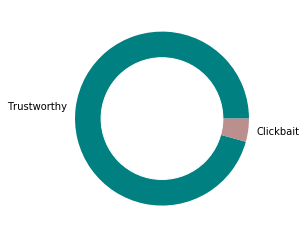

In [161]:
fig=plt.Circle((0,0), 0.7, color='white')

plt.pie(size, labels=names, colors=['teal', 'rosybrown'])
p=plt.gcf()
p.gca().add_artist(fig)
plt.show()

In [169]:
sent_count = lambda x : 0 if x is None else len([s for s in sent_tokenize(x) if s is not None])
word_count = lambda x :  0 if x is None else len([w for w in word_tokenize(x) if w.isalpha() and w is not None])

In [162]:
news18 = news18.dropna(subset=['text', 'title']).copy(deep=True)

In [167]:
tqdm_notebook.pandas(desc="Length (sentences)")

news["sent-len"] = news.text.progress_apply(sent_count)

In [170]:
tqdm_notebook.pandas(desc="Length (words)")

news["word-len"] = news.text.progress_apply(word_count)

In [171]:
news.to_json("../data/interim/newsdump-word-sent-count.json", force_ascii=False, compression='gzip')
news.head(10)

,doc_id,docdate,text,title,url,source,year,sent-len,word-len
0,124272138,2018-11-20 15:23:00,Россия поставила Анголе четыре истреьителя Су-...,Россия поставила Анголе четыре истребителя Су-...,http://www.interfax.ru/world/638657,Interfax,2018,11,183
1,124272120,2018-11-20 15:10:00,Нерезиденты и дочерние иностранные банки в окт...,Нерезиденты в октябре купили ОФЗ на аукционах ...,http://www.interfax.ru/business/638658,Interfax,2018,12,239
2,124257606,2018-11-20 14:26:00,Отделение Пенсионного фонда России по Самарско...,Нескольких умерших жителей Самары по ошибке пр...,http://www.interfax.ru/russia/638651,Interfax,2018,3,89
3,124067142,2018-11-19 19:47:00,"Глава дипломатии ЕС Федерика Могерини заявила,...","ЕС предпримет меры из-за ""чрезмерных инспекций...",http://www.interfax.ru/world/638545,Interfax,2018,8,159
4,122766500,2018-11-14 18:45:00,Сотруднику Центрального научно-исследовательск...,Предложенная ученому Кудрявцеву сделка со след...,http://www.interfax.ru/russia/637890,Interfax,2018,20,371
5,111234126,2018-09-04 11:17:00,"Министр цифрового развития, связи и массовых к...",В Минкомсвязи заявили об отсутствии причин мен...,http://www.interfax.ru/russia/627814,Interfax,2018,20,378
6,111234125,2018-09-04 11:11:00,Немногим более половины россиян знают о ситуац...,Половина россиян оказалась не в курсе ситуации...,http://www.interfax.ru/russia/627813,Interfax,2018,8,183
7,111234101,2018-09-04 11:28:00,Следственное управление СКР по Самарской облас...,СК возбудил дело после гибели рабочих на двига...,http://www.interfax.ru/russia/627815,Interfax,2018,7,149
8,111233244,2018-09-04 10:31:00,"Доллар США растет, евро стабилен на Московской...",Рубль умеренно снизился к бивалютной корзине н...,http://www.interfax.ru/business/627806,Interfax,2018,17,324
9,111233239,2018-09-04 10:30:00,"Страховая компания ""Ингосстрах"" начала принима...","Ингосстрах"" начал принимать заявления от клиен...",http://www.interfax.ru/business/627805,Interfax,2018,15,313


In [172]:
news = news[news["word-len"]>5].copy(deep=True)

In [174]:
print("Size of dataframe: {}".format(news.shape[0]))
print("Average number of sentences: {}".format(round(np.mean(news["sent-len"].tolist()), ndigits=2)))
print("Maximum number of sentences: {}".format(max(news["sent-len"].tolist())))
print("Minimum number of sentences: {}".format(min(news["sent-len"].tolist())))

Size of dataframe: 1238106
Average number of sentences: 15.35
Maximum number of sentences: 1857
Minimum number of sentences: 1


In [175]:
print("Average number of words: {}".format(round(np.mean(news["word-len"].tolist()), ndigits=2)))
print("Maximum number of words: {}".format(max(news["word-len"].tolist())))
print("Minimum number of words: {}".format(min(news["word-len"].tolist())))

Average number of words: 247.15
Maximum number of words: 26778
Minimum number of words: 6


In [177]:
bound_s = int(np.mean(news["sent-len"].tolist()) + 2 * np.std(news["sent-len"].tolist()))
bound_w = int(np.mean(news["word-len"].tolist()) + 2 * np.std(news["word-len"].tolist()))

print("Highest bound for number of sentences in text: {}".format(bound_s))
print("Highest bound for number of words in text: {}".format(bound_w))

Highest bound for number of sentences in text: 54
Highest bound for number of words in text: 795


In [180]:
print("Number of empty (?) texts: {}".format(news[news["word-len"]<7].shape[0]))
news[news["word-len"]<7]

Number of empty (?) texts: 63


,doc_id,docdate,text,title,url,source,year,sent-len,word-len
89448,122825823,2018-11-14 11:00:00,"новые акценты в работе налоговых органов"".","Пресс-конференция в ""Интерфаксе"" руководителя ...",http://www.interfax.ru/presscenter/announce/2471,Interfax,2018,1,6
159716,9885227,2017-05-07 15:59:00,Победный гол на 49-й минуте забил Лобжанидзе,"Футболисты ""Оренбурга"" победили ""Краснодар"" 1:...",http://www.kp.ru/online/news/2738348/,KP,2017,1,6
250838,2573246,2017-03-20 10:09:00,Фото: Евгений Фельдман для кампании Навального,Навального облили зеленкой в Барнауле. Фотография,https://meduza.io/short/2017/03/20/navalnogo-o...,Meduza,2017,1,6
276712,1309307,2016-03-07 13:47:00,Фотоистория Евгения Фельдмана \n\nФотоистория ...,"Новый Орлеан, Луизиана. Джаз, бокс, Трамп и Кл...",http://www.novayagazeta.ru/photos/72127.html?p...,Novaya Gazeta,2016,1,6
281234,111338683,2018-09-04 18:31:00,Новые (старые) методы агитации на выборы,Явка на шашлыки,https://www.novayagazeta.ru/articles/2018/09/0...,Novaya Gazeta,2018,1,6
289232,99825320,2018-07-23 00:47:00,"*Роман Якобсон, «Статуя в поэтической мифологи...",70-й день бессрочной голодовки,https://www.novayagazeta.ru/articles/2018/07/2...,Novaya Gazeta,2018,1,6
294318,70980728,2018-03-30 11:42:00,Арсений ​Рогинский​ — о себе и о стране,Право на Память. Фильм,https://www.novayagazeta.ru/articles/2018/03/3...,Novaya Gazeta,2018,1,6
375846,61515570,2018-02-26 18:15:00,Источник: Локальный центр МГУ имени М.В. Ломон...,Пройдите тест на знание русского языка для пол...,https://rg.ru/2018/02/26/projdite-test-na-znan...,RG,2018,2,6
496685,689686,2016-12-23 12:30:00,Освобожденный от террористов Алеппо — в фотоле...,Праздник победы над террористами в освобожденн...,http://ria.ru/syria_mm/20161223/1484396752.html,RIA,2016,1,6
500657,693652,2017-02-14 16:52:00,ПАРЛАМЕНТ ЕГИПТА СМЕНИЛ ДЕВЯТЬ МИНИСТРОВ — ТВ,Египетский парламент сменил девять министров,http://ria.ru/world/20170214/1487958609.html,RIA,2017,1,6


<Figure size 432x288 with 0 Axes>

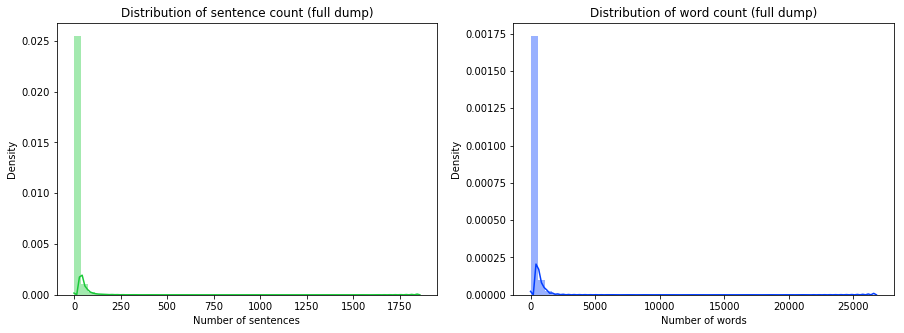

In [186]:
# clear current figure
plt.clf()

# create plt.Figure with 2 subplots
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.set_color_codes(palette="bright")

# create Number Of Sentences distplot 
plt1 = sns.distplot(news["sent-len"].tolist(), ax=axes[0], color="g")
plt1.set(xlabel = "Number of sentences", ylabel="Density")
plt1.set_title("Distribution of sentence count (full dump)")

# create Number Of Words distplot 
plt2 = sns.distplot(news["word-len"].tolist(), ax=axes[1], color="b")
plt2.set(xlabel = "Number of words", ylabel="Density")
plt2.set_title("Distribution of word count (full dump)")

#show graphs
plt.show()

In [188]:
print("Large by sent-count (over {0} sentences): {1}% of dataset".format(bound_s, 
                                                                         round(news[news["sent-len"]>bound_s].shape[0]*100/news.shape[0], 
                                                                               ndigits=3)))
print("Large by word-count (over {0} words): {1}% of dataset".format(bound_w, 
                                                                     round(news[news["word-len"]>bound_w].shape[0]*100/news.shape[0], 
                                                                           ndigits=3)))

Large by sent-count (over 54 sentences): 2.992% of dataset
Large by word-count (over 795 words): 3.679% of dataset


#### ok, drop big bois

<Figure size 432x288 with 0 Axes>

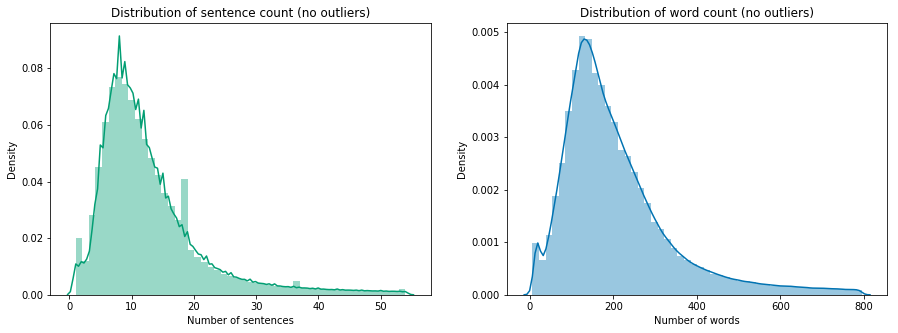

In [203]:
# clear current figure
plt.clf()

# create plt.Figure with 2 subplots
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.set_color_codes(palette="colorblind")

# create Number Of Sentences distplot
plt1 = sns.distplot(news[news["sent-len"]<=bound_s]["sent-len"].tolist(), ax=axes[0], color="g")
plt1.set(xlabel = "Number of sentences", ylabel="Density")
plt1.set_title("Distribution of sentence count (no outliers)")

# create Number Of Words distplot 
plt2 = sns.distplot(news[news["word-len"]<=bound_w]["word-len"].tolist(), ax=axes[1], color="b")
plt2.set(xlabel = "Number of words", ylabel="Density")
plt2.set_title("Distribution of word count (no outliers)")

# show graphs
plt.show()

## So it's probably wise to drop all outliers by sentence/word count

In [198]:
news = news[(news["sent-len"] <= bound_s) | (news["word-len"] <= bound_w)]
print("Size of DataFrame: {}".format(news.shape[0]))

Size of DataFrame: 1205656


## And same old graph story for 2018 part of dataset

In [199]:
news18 = news[news["docdate"]>pd.to_datetime("2018", format="%Y")]
print("News dated back in 2018: {}".format(news18.shape[0]))
news18.head(10)

News dated back in 2018: 504485


,doc_id,docdate,text,title,url,source,year,sent-len,word-len
0,124272138,2018-11-20 15:23:00,Россия поставила Анголе четыре истреьителя Су-...,Россия поставила Анголе четыре истребителя Су-...,http://www.interfax.ru/world/638657,Interfax,2018,11,183
1,124272120,2018-11-20 15:10:00,Нерезиденты и дочерние иностранные банки в окт...,Нерезиденты в октябре купили ОФЗ на аукционах ...,http://www.interfax.ru/business/638658,Interfax,2018,12,239
2,124257606,2018-11-20 14:26:00,Отделение Пенсионного фонда России по Самарско...,Нескольких умерших жителей Самары по ошибке пр...,http://www.interfax.ru/russia/638651,Interfax,2018,3,89
3,124067142,2018-11-19 19:47:00,"Глава дипломатии ЕС Федерика Могерини заявила,...","ЕС предпримет меры из-за ""чрезмерных инспекций...",http://www.interfax.ru/world/638545,Interfax,2018,8,159
4,122766500,2018-11-14 18:45:00,Сотруднику Центрального научно-исследовательск...,Предложенная ученому Кудрявцеву сделка со след...,http://www.interfax.ru/russia/637890,Interfax,2018,20,371
5,111234126,2018-09-04 11:17:00,"Министр цифрового развития, связи и массовых к...",В Минкомсвязи заявили об отсутствии причин мен...,http://www.interfax.ru/russia/627814,Interfax,2018,20,378
6,111234125,2018-09-04 11:11:00,Немногим более половины россиян знают о ситуац...,Половина россиян оказалась не в курсе ситуации...,http://www.interfax.ru/russia/627813,Interfax,2018,8,183
7,111234101,2018-09-04 11:28:00,Следственное управление СКР по Самарской облас...,СК возбудил дело после гибели рабочих на двига...,http://www.interfax.ru/russia/627815,Interfax,2018,7,149
8,111233244,2018-09-04 10:31:00,"Доллар США растет, евро стабилен на Московской...",Рубль умеренно снизился к бивалютной корзине н...,http://www.interfax.ru/business/627806,Interfax,2018,17,324
9,111233239,2018-09-04 10:30:00,"Страховая компания ""Ингосстрах"" начала принима...","Ингосстрах"" начал принимать заявления от клиен...",http://www.interfax.ru/business/627805,Interfax,2018,15,313


<Figure size 432x288 with 0 Axes>

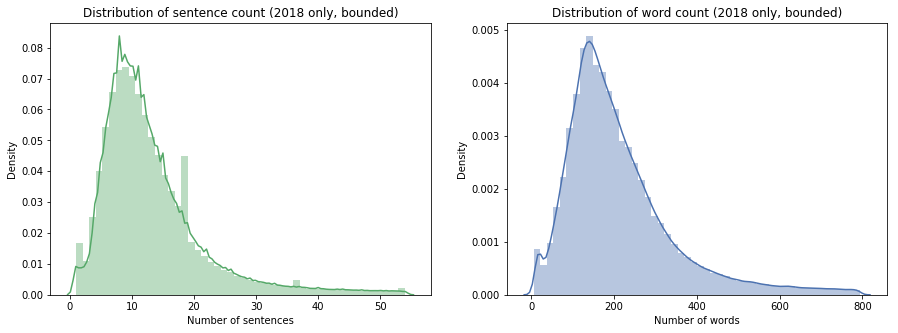

In [205]:
# clear current figure
plt.clf()

# create plt.Figure with 2 subplots
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.set_color_codes(palette="deep")

# create Number Of Sentences distplot
plt1 = sns.distplot(news18[news18["sent-len"]<=bound_s]["sent-len"].tolist(), ax=axes[0], color="g")
plt1.set(xlabel = "Number of sentences", ylabel="Density")
plt1.set_title("Distribution of sentence count (2018 only, bounded)")

# create Number Of Words distplot 
plt2 = sns.distplot(news18[news18["word-len"]<=bound_w]["word-len"].tolist(), ax=axes[1], color="b")
plt2.set(xlabel = "Number of words", ylabel="Density")
plt2.set_title("Distribution of word count (2018 only, bounded)")

# show graphs
plt.show()

<Figure size 432x288 with 0 Axes>

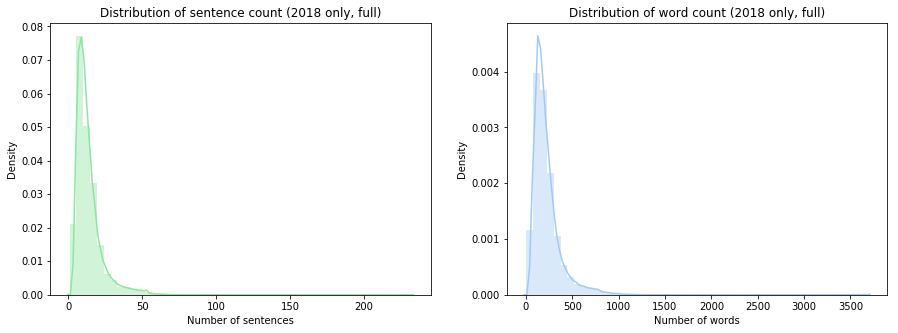

In [207]:
# clear current figure
plt.clf()

# create plt.Figure with 2 subplots
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.set_color_codes(palette="pastel")

# create Number Of Sentences distplot
plt1 = sns.distplot(news18["sent-len"].tolist(), ax=axes[0], color="g")
plt1.set(xlabel = "Number of sentences", ylabel="Density")
plt1.set_title("Distribution of sentence count (2018 only, full)")

# create Number Of Words distplot 
plt2 = sns.distplot(news18["word-len"].tolist(), ax=axes[1], color="b")
plt2.set(xlabel = "Number of words", ylabel="Density")
plt2.set_title("Distribution of word count (2018 only, full)")

# show graphs
plt.show()

In [210]:
unlabeled, to_label = train_test_split(news18, test_size=0.01, stratify=news18["source"])

In [227]:
to_label.to_json("../data/interim/to-label.json", force_ascii=False)

In [228]:
to_label.to_csv("../data/interim/to-label.csv", encoding="utf-8")

In [ ]:
unlabeled.to_json("../data/interim/unlabeled.json", force_ascii=False, compression='zip')

## Exploring RuStance a bit

In [5]:
rustance = pd.read_csv("../data/external/rustance.csv", sep=";", error_bad_lines=False)

In [6]:
rustance.head()

,Stance,Text,Title
0,c,"Волки, волки!!",Минобороны обвинило «гражданского сотрудника» ...
1,c,"@(Vitaly Stativ) ту мач, суток хватит",Минобороны обвинило «гражданского сотрудника» ...
2,c,"@(Terkin Vasily) Ну, в Арме таких конвоев длин...",Минобороны обвинило «гражданского сотрудника» ...
3,c,МО скинуло афтершоку цветные фотки https://aft...,Минобороны обвинило «гражданского сотрудника» ...
4,c,а нет звезде,Минобороны обвинило «гражданского сотрудника» ...


In [7]:
rustance.shape[0]

958